In [1]:
import torch
import lightning as L
from gpsr.custom_cheetah.screen import Screen
from cheetah import ParticleBeam
from gpsr.modeling import GPSR, GPSRQuadScanLattice
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator
from gpsr.datasets import QuadScanDataset

In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6  # reference momentum in eV/c

gt_beam = torch.load("../example_data/example_distributions/complex_beam.pt")
gt_beam = ParticleBeam(
    gt_beam.particles,
    gt_beam.energy
)

C:\Users\Ryan Roussel\AppData\Local\Temp\ipykernel_21260\1493527286.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gt_beam = torch.load("../example_data/example_distrib

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


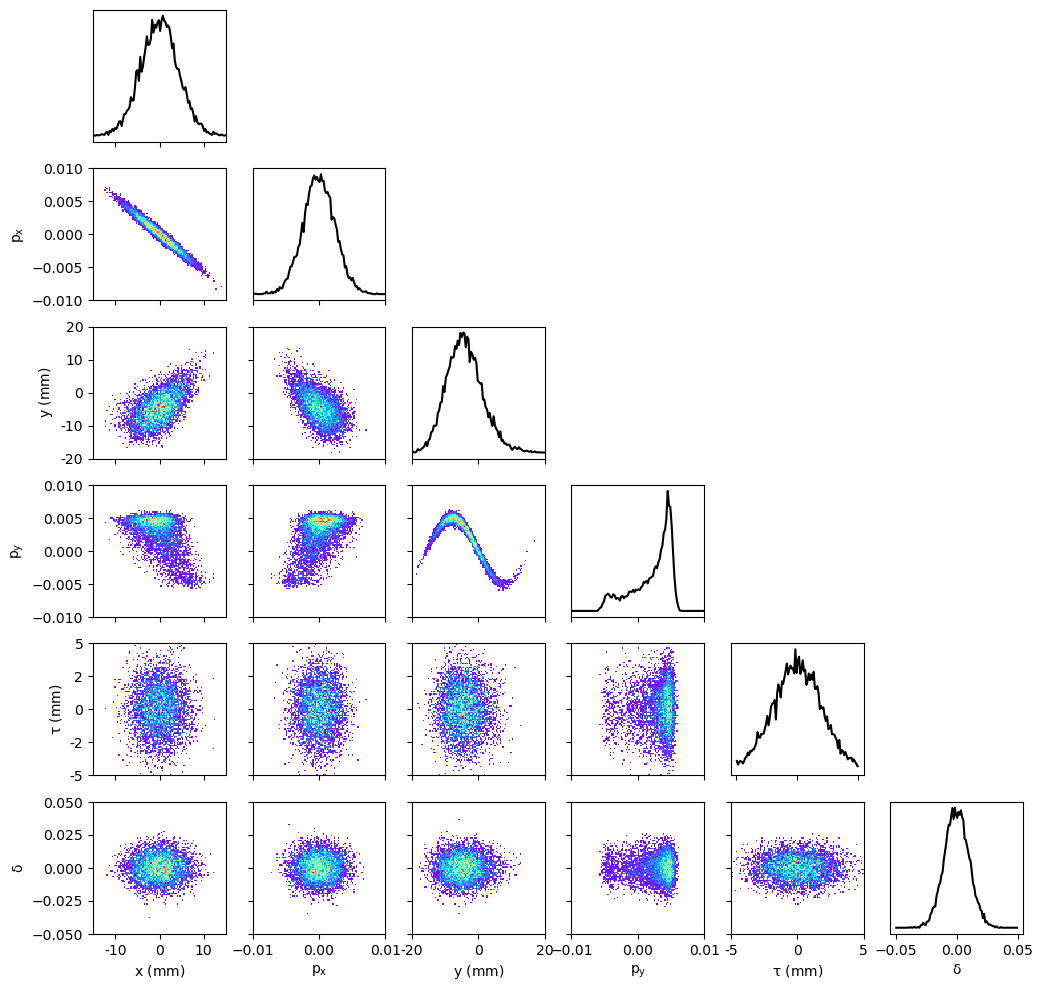

In [3]:
# plot synthetic ground truth beam projections
import numpy as np

lims = [
        [-15e-3, 15e-3],
        [-10e-3, 10e-3],
        [-20e-3, 20e-3],
        [-10e-3, 10e-3],
        [-5e-3, 5e-3],
        [-5e-2, 5e-2],
    ]
gt_beam.plot_distribution(bin_ranges=lims);

In [4]:
# create diagnostic screen:
n_pixels = 100
pixel_size = torch.tensor(1e-3)
screen = Screen(
    resolution=(n_pixels, n_pixels), 
    pixel_size=torch.tensor((pixel_size, pixel_size)),
    method="kde",
    kde_bandwidth=pixel_size / 2,
    is_active=True,
)

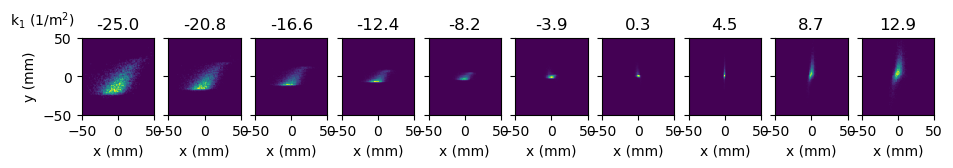

In [5]:
# create synthetic data
# get model
gpsr_lattice = GPSRQuadScanLattice(
    l_quad=0.1, l_drift=1.0, diagnostic=screen
)

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-25, 15, n_ks)
gpsr_lattice.set_lattice_parameters(ks)

# propagate beam and get images
images = gpsr_lattice.track_and_observe(gt_beam)[0]

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

train_images = images[::2]
test_images = images[1::2]

train_dset = QuadScanDataset(train_ks, train_images, screen=screen)
test_dset = QuadScanDataset(test_ks, test_images, screen=screen)

train_dset.plot_data();

In [6]:
torch.save(train_dset, "../example_data/example_datasets/reconstruction_4D_train.dset")
torch.save(test_dset, "../example_data/example_datasets/reconstruction_4D_test.dset")

In [7]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(limit_train_batches=100, max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
c:\ProgramData\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\ProgramData\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interv

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 27.05it/s, v_num=8]


In [8]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

## Evaluate model on test samples to compare predictions

In [9]:
test_pred = gpsr_model(test_ks)[0].detach()
test_pred_dset = QuadScanDataset(test_ks, test_pred, screen=screen)

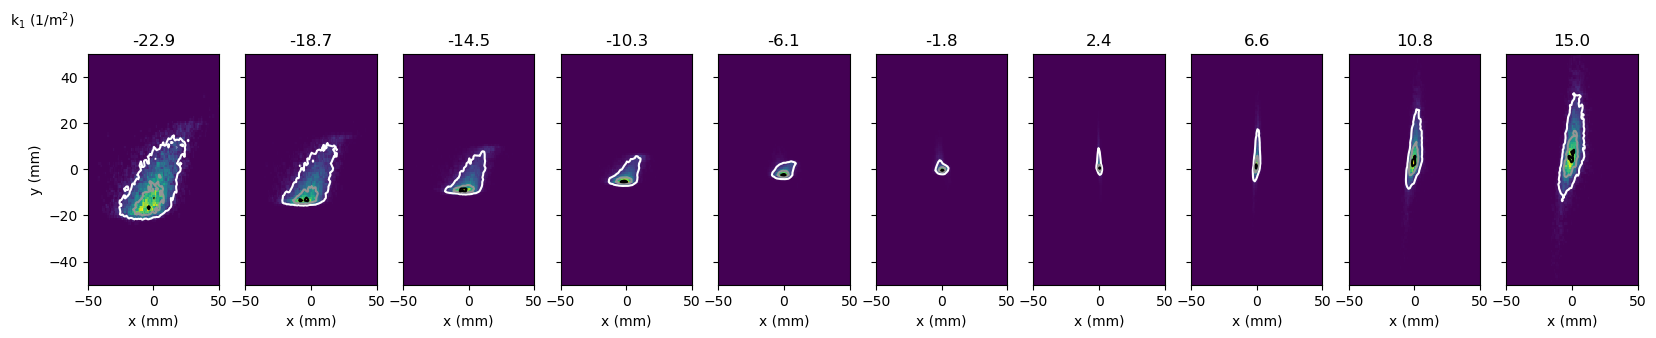

In [10]:
fig, ax = test_dset.plot_data(overlay_data=test_pred_dset)
fig.set_size_inches(20, 3)

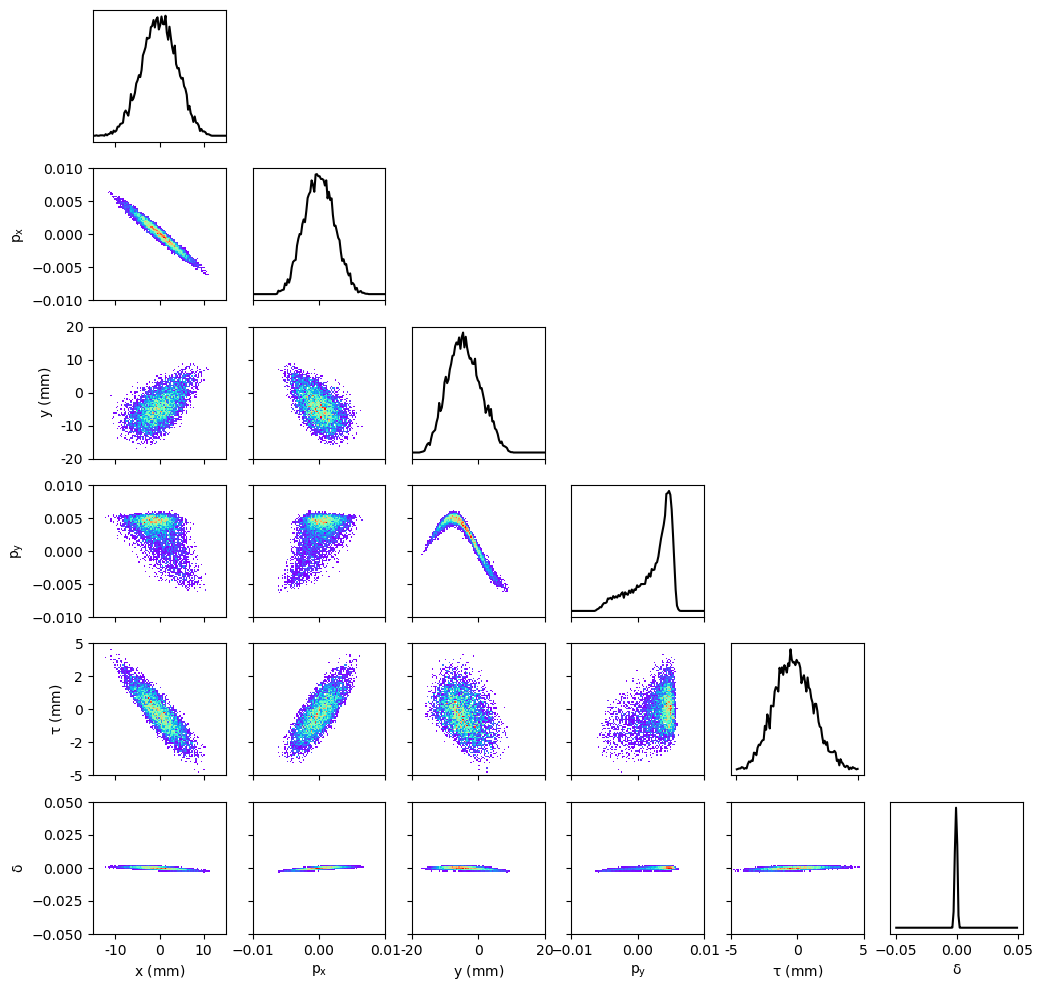

In [11]:
reconstructed_beam.plot_distribution(bin_ranges=lims);